Amanda M., Simon R.

# ADAMS Mini Challenge 1

## Import packages and setup

In [1]:
import pandas as pd
import numpy as np
import keras as keras
import matplotlib.pyplot as plt
import io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
import h5py 
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

Using TensorFlow backend.


## Load data

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
  df = pd.read_csv(io.BytesIO(uploaded['ConversionDataSet.csv'])) # Save data in pandas data frame

Saving ConversionDataSet.csv to ConversionDataSet.csv
User uploaded file "ConversionDataSet.csv" with length 17702604 bytes


In [ ]:
df = pd.read_csv('ConversionDataSet.csv') #if session crashes and data was already uploaded

In [4]:
df.head(3)

,Unnamed: 0,month,Kauf,sessionStartHour,dayOfMonth,weekday,sessionTime,category,pageVisitedBeforeSession,amountBasketSession,totalItemValueBasketSession,sessionProduct,sessionSearch,sessionOverview,sessionSale,sessionCart,percPageProduct,percPageSearch,percPageOverview,percPageSale,percPageCart,countPagesRevisited,timeOnPage,checkoutStep,clickEventsSession,scrollEventSession,tabSwitchSession,clickEventProduct,scrollEventProduct,tabSwitchProduct,clickEventSearch,scrollEventSearch,tabSwitchSearch,clickEventOverview,scrollEventOverview,tabSwitchOverview,clickEventSale,scrollEventSale,tabswitchSale,clickEventCart,...,recencyVisit,countPagesRevisitedLastSession,currentPageVisitedLastTime,frequencyVisit,totViewCount,totVisitTime,totPurchasesAmount,totPurchasesItems,totProduct,totSearch,totOverview,totSale,totCart,totPercPageOverview,totPercPageProduct,totPercPageSearch,totPercPageSale,totPercPageCart,convertedBefore,hurry,currentViewCountVsPreviousAvg,currentVisitLengthVsAvg,meanRecencyVisit,pageProductrVisit,pageSearchrVisit,pageOverviewrVisit,pageSalerVisit,pageCartrVisit,purchasesrVisit,browser,browserVersion,operatingSystem,operatingSystemVersion,majorCity,screenWidth,screenHeight,windowWidth,windowHeight,tabVisible,visitorKnown
0,4,8,0,21,1,6,20,overview,0,0.0,0,0,0,1,1,0,0.0,0.00,0.33,0.33,0.0,0,6,0,3,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.333333,0.0,0.0,0.5,0.0,0.0,0.0,...,-1,0,0,0,3,20,0.0,0,0,0,1,1,0,0.0,0.00,0.33,0.33,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,IE,1,Windows 7,1,0,1280,1024,1280,844,1,0
1,14,8,0,0,1,6,85,search,1,0.0,0,0,2,0,0,0,0.0,0.67,0.00,0.00,0.0,1,34,0,5,10,3,0.0,0.0,0.0,0.266667,0.112741,0.703125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,85,0.0,0,0,2,0,0,0,0.0,0.67,0.00,0.00,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,Firefox,2,Windows 8,1,0,1366,768,1339,634,1,1
2,51,8,0,10,1,6,23,overview,0,0.0,0,0,0,2,0,0,0.0,0.00,0.67,0.00,0.0,0,4,0,3,2,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.500000,0.5,0.0,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,23,0.0,0,0,0,2,0,0,0.0,0.00,0.67,0.00,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,Chrome,2,Windows 8.1,1,0,1600,900,1600,799,1,1


Separate the dataset into the predictors X and target y

In [ ]:
X = df.drop(['Kauf', 'Unnamed: 0'], axis=1)
y = df["Kauf"]

## Data Analysis and Preprocessing

In the following section we will explore the data set and get familiar with some main aspects that might be important for building our neural network later on. 

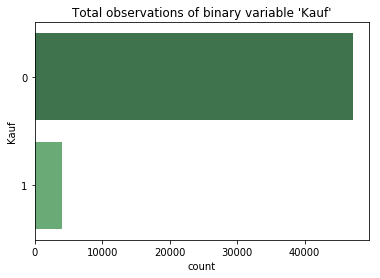

In [6]:
plt.title("Total observations of binary variable 'Kauf'") 
sns.countplot(y="Kauf", data=df,
 palette="Greens_d")

In [8]:
class_counts = df.groupby('Kauf').size()
print(class_counts)
print("\n")
print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)
#print('Only', round(100*y.mean(),2), 'percent of clients bought something during this specific session.

Kauf
0    47237
1     4112
dtype: int64


Shape of X:  (51349, 95)
Shape of y:  (51349,)


As only 8.01 %  of the clients have bought something (also illustrated in the first chart), we are dealing with an unbalanced data set. With regard to the set up of the neural network this is a particularly interesting point to keep in mind. 


---



In [9]:
pd.isnull(df).any() # No Null values can be found

Unnamed: 0                       False
month                            False
Kauf                             False
sessionStartHour                 False
dayOfMonth                       False
weekday                          False
sessionTime                      False
category                         False
pageVisitedBeforeSession         False
amountBasketSession              False
totalItemValueBasketSession      False
sessionProduct                   False
sessionSearch                    False
sessionOverview                  False
sessionSale                      False
sessionCart                      False
percPageProduct                  False
percPageSearch                   False
percPageOverview                 False
percPageSale                     False
percPageCart                     False
countPagesRevisited              False
timeOnPage                       False
checkoutStep                     False
clickEventsSession               False
scrollEventSession       

In [ ]:
df.dtypes #Checking data types 



---


If we have a closer look at the customers concerning their total view count we can interestingly state that customers who did purchase in the given period have a slightly lower total view count. Those who already bought something have about twice as much view counts in average but again customers who did purchase in the given period have a slightly lower total view count. 




In [ ]:
print(df['convertedBefore'].value_counts()) # 8263 of 43086 clients have converted before
print(df['totPurchasesAmount'].describe()) # Average total purchase amount during all sessions is 11.4
print(df['totPurchasesItems'].value_counts()) # 47031 have a total of 0 purchased items during all sessions


In [ ]:
g = sns.catplot(x="convertedBefore", y="totViewCount", hue="Kauf", data=df,
                 kind="bar", palette="muted")

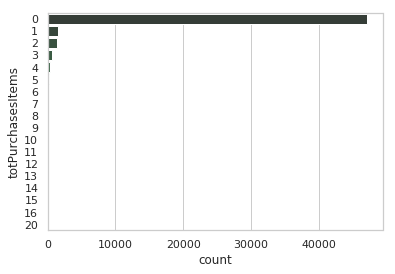

In [ ]:
sns.countplot(y="totPurchasesItems", data=df,
 palette="Greens_d")

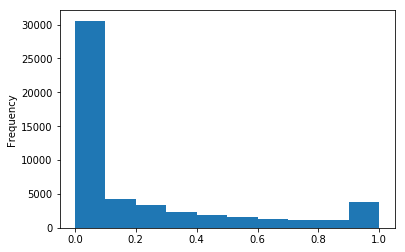

In [13]:
df['timeSpentOnProduct'].plot(kind="hist") #Frequency of relative amount of time on pages of type 'product'

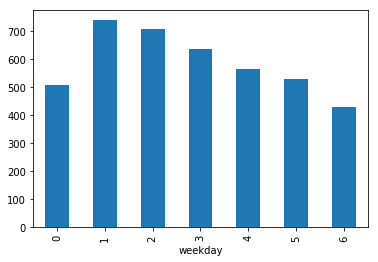

In [ ]:
df.groupby(['weekday']).sum()['Kauf'].plot.bar() # Number of 'Kauf' events per weekday

The chart above illustrates that the total number of sales is decreasing after weekday 1 whereas it is increasing from weekday 0 to 1.



---


As we can see in the follwing two charts, there are slightly more sales made in month 9 on weekday 2 but in contrast to that
the total number of purchased items is slightly higher in month 8 on weekday 4 and 5. Note that the numbers refer to an overall average across the whole dataset. 

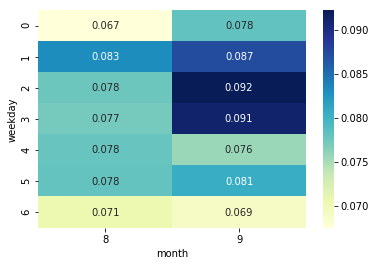

In [15]:
df1 = df[['weekday','month','Kauf']]
heat_data = pd.pivot_table(df1, values='Kauf', 
                     index=['weekday'], 
                     columns='month')
sns.heatmap(heat_data, cmap="YlGnBu",annot=True)

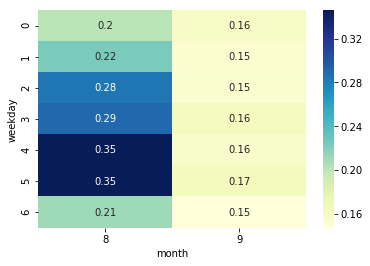

In [16]:
df2 = df[['weekday','month','totPurchasesItems']]
heat_data2 = pd.pivot_table(df2, values='totPurchasesItems', 
                     index=['weekday'], 
                     columns='month')
sns.heatmap(heat_data2, cmap="YlGnBu",annot=True)


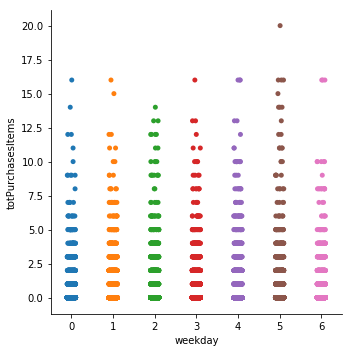

In [17]:
sns.catplot(x="weekday", y="totPurchasesItems", data=df);
#The number of total items purchased has 

The next chart tells us, that most of the views are made in average on the account category throughtout the whole week. The imbalanced nature of the data can also be recognised here, as there are the fewest view counts in avergae on the checkout page. Due to the fact that the checkout is the last step in the sales funnel this also seems to be a trivial fact. 

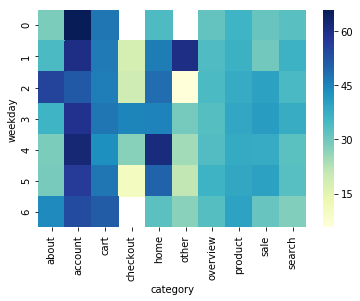

In [18]:
df3 = df[['weekday','category','totViewCount']]
heat_data3 = pd.pivot_table(df3, values='totViewCount', 
                     index=['weekday'], 
                     columns='category')
sns.heatmap(heat_data3, cmap="YlGnBu")

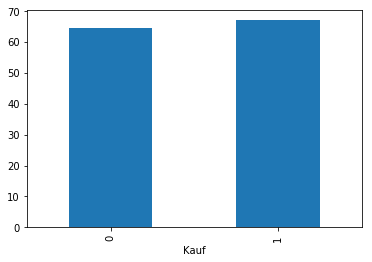

In [19]:
df.groupby(['Kauf']).mean()['timeOnPage'].plot(kind='bar') # Average time on page for Kauf and no Kauf does not vary much

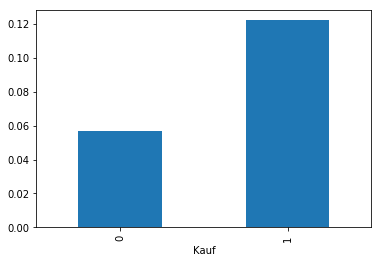

In [20]:
df.groupby(['Kauf']).mean()['purchasesrVisit'].plot(kind='bar')

## Set up NN structure

**Define relevant functions**

In [ ]:
# Define functions for sensitivity (true positive rate) and specificity (true negative rate) and false positive rate
from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def falsepositive(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    return 1 - true_negatives

def show_history(story):
    plt.plot(story.history['acc'])
    plt.plot(story.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

**Define callbacks for early stopping and AUC**

In [ ]:
# Define early stopping with callbacks
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.5, patience=30, restore_best_weights=True) # Stop training when loss decreases less than 1%
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) # Save best model and print parameters


# Define Callback for AUC
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
    

**Use one hot encoding to transform categorical data.**

In [ ]:
X= pd.get_dummies(X, prefix_sep="_",columns=X.select_dtypes(include=[object]).columns) # One hot encoding to transform categorical data
#X.head(10)
#print(X.dtypes)
#print(X.shape,y.shape)

**Split data into training and test sets**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34403, 128) (16946, 128) (34403,) (16946,)


**Standardize numeric variables**

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test= scaler.transform(X_test)  

In [ ]:
seed=40

In [27]:
model = Sequential()

model.add(Dense(128, 
                activation='relu', 
                kernel_initializer=keras.initializers.he_normal(seed=seed),
                bias_initializer='zeros', 
                input_shape=(128,))) 
model.add(Dense(128, activation='relu',kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')) 
model.add(Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros'))


Instructions for updating:
Colocations handled automatically by placer.


In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 33,153
Trainable params: 33,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
from keras import optimizers
opt = optimizers.SGD(lr=0.01)

model.compile(
    loss='binary_crossentropy', # Loss function that will be minimized
    optimizer=opt,
    metrics=[sensitivity, specificity, falsepositive, 'accuracy'] # Metrics that will be reported
)

In [30]:
batch_size =32 
epochs = 30


story = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,validation_data=(X_test, y_test))


Instructions for updating:
Use tf.cast instead.
Train on 34403 samples, validate on 16946 samples
Epoch 1/30
34403/34403 [==============================] - 7s 190us/step - loss: 0.2847 - sensitivity: 0.1012 - specificity: 0.9886 - falsepositive: -28.0962 - acc: 0.9181 - val_loss: 0.2569 - val_sensitivity: 0.1574 - val_specificity: 0.9883 - val_falsepositive: -28.0827 - val_acc: 0.9223
Epoch 2/30
34403/34403 [==============================] - 4s 106us/step - loss: 0.2516 - sensitivity: 0.1353 - specificity: 0.9911 - falsepositive: -28.1707 - acc: 0.9234 - val_loss: 0.2513 - val_sensitivity: 0.1618 - val_specificity: 0.9887 - val_falsepositive: -28.0960 - val_acc: 0.9232
Epoch 3/30
34403/34403 [==============================] - 4s 107us/step - loss: 0.2445 - sensitivity: 0.1425 - specificity: 0.9919 - falsepositive: -28.1948 - acc: 0.9245 - val_loss: 0.2480 - val_sensitivity: 0.1532 - val_specificity: 0.9903 - val_falsepositive: -28.1450 - val_acc: 0.9240
Epoch 4/30
34403/34403 [========

### Model evaluation

In [31]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

16946/16946 [==============================] - 1s 51us/step
Test loss: 0.2720528645367292
Test accuracy: 0.21309368964647382


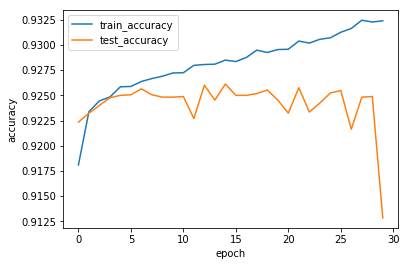

In [32]:
show_history(story)

In [ ]:
predictions = model.predict(X_test)
predictions
pred_bin = pd.DataFrame(predictions).round(0)
pred_bin = pred_bin.astype(int)
#print(pred_bin)


In [34]:
#target_names = ["0"]
print ('\nClasification report:\n', classification_report(pd.DataFrame(y_test), pred_bin))
print ('\nConfusion matrix:\n', confusion_matrix(pd.DataFrame(y_test), pred_bin))


Clasification report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     15593
           1       0.42      0.23      0.30      1353

   micro avg       0.91      0.91      0.91     16946
   macro avg       0.68      0.60      0.63     16946
weighted avg       0.89      0.91      0.90     16946


Confusion matrix:
 [[15155   438]
 [ 1039   314]]


In [35]:
# calculate AUC for test set
roc_auc_score(y_test, predictions) # AUC is 0.72


0.7214516112442481

In the above neural network a batch size of 32 and 30 epochs led to an AUC value of 0.72. The plot of test and training accuracy illustrates that the accuracy keeps rising for the training set, while accuracy for the test set drops significantly between 20 and 30 epochs. This suggests that the neural network is overfitting. The confusion matrix reveals, that the model reconizes obersvations where nothing was bought quite good, while obervations in which a purchase took place are recognized with much lower precision.

## Model Tuning

In [36]:
# Build model
model2 = Sequential()

model2.add(Dense(128, 
                activation='relu', 
                kernel_initializer=keras.initializers.he_normal(seed=seed),
                bias_initializer='zeros', 
                input_shape=(128,)))
model2.add(Dropout(0.3)) # Drop out
model2.add(Dense(128, activation='relu',kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros'))
model2.add(Dropout(0.3)) # Drop out
model2.add(Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros'))

# Compile model
epochs = 30
batch_size =64 
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

model2.compile(
    loss='binary_crossentropy', # Loss function that will be minimized
    optimizer=sgd,
    metrics=[sensitivity, specificity, falsepositive, 'accuracy'] # Metrics that will be reported
)




# Create weights for unbalanced class
df.groupby('Kauf').size()[0]
t = 0.5 #  t∈[0,1] where t=1 means that we only pay attention to sensitivity, t=0 means we only pay attention to specificity and t=0.5 means that we regard both to be equally important
weight = df.groupby('Kauf').size()[0] / df.groupby('Kauf').size()[1] * t
#print(weight)
class_weights = {0: 1.,
                1: weight} 


story2 = model2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,validation_split=0.3,
                  callbacks=[roc_callback(training_data=(X_train, y_train),validation_data=(X_test, y_test)), es])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 24082 samples, validate on 10321 samples
Epoch 1/30
24082/24082 [==============================] - 2s 85us/step - loss: 0.2808 - sensitivity: 0.1146 - specificity: 0.9896 - falsepositive: -57.1459 - acc: 0.9181 - val_loss: 0.2433 - val_sensitivity: 0.1558 - val_specificity: 0.9894 - val_falsepositive: -57.3818 - val_acc: 0.9253
roc-auc: 0.7476 - roc-auc_val: 0.7271                                                                                                    
Epoch 2/30
24082/24082 [==============================] - 1s 61us/step - loss: 0.2503 - sensitivity: 0.1165 - specificity: 0.9941 - falsepositive: -57.4018 - acc: 0.9230 - val_loss: 0.2350 - val_sensitivity: 0.0985 - val_specificity: 0.9964 - val_falsepositive: -57.7973 - val_acc: 0.9272
roc-auc: 0.7645 - roc-auc_val: 0.7354                                                                                  


AUC:
 0.744955463319551


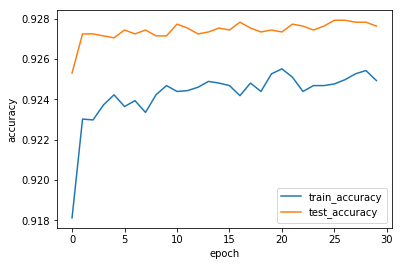


Confusion matrix:
 [[15554    39]
 [ 1206   147]]

Clasification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     15593
           1       0.79      0.11      0.19      1353

   micro avg       0.93      0.93      0.93     16946
   macro avg       0.86      0.55      0.58     16946
weighted avg       0.92      0.93      0.90     16946



In [37]:
print('\nAUC:\n', roc_auc_score(y_test, model2.predict(X_test))) #74.5 for batch size 64 and drop out 0.3
show_history(story2)
print ('\nConfusion matrix:\n', confusion_matrix(pd.DataFrame(y_test), pd.DataFrame(model2.predict(X_test)).round(0)))
print ('\nClasification report:\n', classification_report(pd.DataFrame(y_test), pd.DataFrame(model2.predict(X_test)).round(0)))

In this second neural network a drop out of 30% was incorporated into the network to avoid overfitting. Additionally a larger batch size of 64 was chosen to include more obervations of the unbalanced class per batch. The graph shows that overfitting was less of a problem than in the previous neural network. The network also improved in recognizing purchase events which can be seen in an AUC value of 0.75.

In this mini challenge two neural networks were built and trained to predict purchase events in an online shop. The first model was imporved by incorporating drop out and enlargening batch size. This led to an increase in AUC and precision. 
Further improvements might be accomplished be implementing a grid search over parameters like learning rate, drop out, batch size etc. Additionally more layers could be added to the neural network.